# Baseline model
## Introduction
This notebook contains the baseline model that we need to outperform. The baseline model is a weighted average (seasonal) timeseries forecast for the next 4 quarters.

## Data preparation

In [242]:
import polars as pl
import polars.selectors as cs
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sqlalchemy import create_engine  # ← add this line
from pathlib import Path
from config import DIR_DB_SILVER

# Settings
pl.Config(
    tbl_cols=-1,        # Show all columns
    tbl_rows=20,        # Show 20 rows
    tbl_width_chars=10000  # Prevent truncation due to width limit
)
# --- Database Connection ---
# Check if database exists; handle both root and 'code' directory execution
if not DIR_DB_SILVER.exists():
    if (Path("..") / DIR_DB_SILVER).exists():
        DIR_DB_SILVER = Path("..") / DIR_DB_SILVER
    else:
        raise FileNotFoundError(f"❌ Database not found at {DIR_DB_SILVER}. Ensure you are in the project root.")

# Create a simple SQLAlchemy engine for the Silver database
engine = create_engine(f"sqlite:///{DIR_DB_SILVER}")

# SQL Query to extract and format absenteeism data
query = """
SELECT 
    Perioden as timeperiod_text, 
    BedrijfskenmerkenSBI2008  as sbi_code,
    BedrijfskenmerkenSBI2008_Title as sbi_title,
    DATE(
        printf('%s-%s-01', 
            substr(Perioden, 1, 4), 
            CASE substr(Perioden, 7, 2)
                WHEN '01' THEN '01'
                WHEN '02' THEN '04'
                WHEN '03' THEN '07'
                WHEN '04' THEN '10'
            END
        ), 
        '+3 months', 
        '-1 day'
    ) AS period_enddate,
    CAST(substr(Perioden, 1, 4) as INTEGER) as "year",
    CAST(substr(Perioden, 8, 1) as INTEGER) as "quarter",
    CAST(Ziekteverzuimpercentage_1 AS REAL) as absenteeism_perc
FROM "80072ned_silver"
WHERE Perioden NOT LIKE '%JJ%' 
AND substr(Perioden, 1, 4) >= '2014'
AND UPPER(BedrijfskenmerkenSBI2008_Title) GLOB '[A-U] *'
order by sbi_code, Period_enddate asc
"""

# Load into Polars DataFrame
with engine.connect() as conn:
    df_org = pl.read_database(query=query, connection=conn)

print(f"✅ Success! Loaded {len(df_org)} rows.")
df_org.head()

✅ Success! Loaded 893 rows.


timeperiod_text,sbi_code,sbi_title,period_enddate,year,quarter,absenteeism_perc
str,str,str,str,i64,i64,f64
"""2014KW01""","""301000""","""A Landbouw, bosbouw en visseri…","""2014-03-31""",2014,1,2.4
"""2014KW02""","""301000""","""A Landbouw, bosbouw en visseri…","""2014-06-30""",2014,2,2.3
"""2014KW03""","""301000""","""A Landbouw, bosbouw en visseri…","""2014-09-30""",2014,3,2.5
"""2014KW04""","""301000""","""A Landbouw, bosbouw en visseri…","""2014-12-31""",2014,4,2.9
"""2015KW01""","""301000""","""A Landbouw, bosbouw en visseri…","""2015-03-31""",2015,1,2.9


In [243]:
df_modified = df_org.with_columns(
    # Convert columns ending with 'date' to Date type
    cs.ends_with("date").str.to_date("%Y-%m-%d"),
)
df_modified.sort("period_enddate", descending=True).head()

timeperiod_text,sbi_code,sbi_title,period_enddate,year,quarter,absenteeism_perc
str,str,str,date,i64,i64,f64
"""2025KW03""","""301000""","""A Landbouw, bosbouw en visseri…",2025-09-30,2025,3,3.3
"""2025KW03""","""305700""","""B Delfstoffenwinning""",2025-09-30,2025,3,5.0
"""2025KW03""","""307500""","""C Industrie""",2025-09-30,2025,3,5.9
"""2025KW03""","""346600""","""D Energievoorziening""",2025-09-30,2025,3,4.3
"""2025KW03""","""348000""","""E Waterbedrijven en afvalbehee…",2025-09-30,2025,3,6.5


#### Year-on-Year Moving Average Prediction Model
**Goal:** <br> For each quarter (Q1/Q2/Q3/Q4) and sbi_code, calculate a rolling 3-year moving average of Absenteeism_perc as a simple prediction.
Example: The prediction for Q1-2019 = average of Q1-2016, Q1-2017, Q1-2018.

**Step 1: Sort the Data** <br>
Polars window functions respect row order, so we must sort by sbi_code, quarter, and year to ensure the rolling average looks back over the correct preceding years (e.g. 2016 → 2017 → 2018 for a Q1 prediction of 2019).

In [244]:
df_sorted = df_modified.sort(["sbi_code", "quarter", "year"])
df_sorted.head()

timeperiod_text,sbi_code,sbi_title,period_enddate,year,quarter,absenteeism_perc
str,str,str,date,i64,i64,f64
"""2014KW01""","""301000""","""A Landbouw, bosbouw en visseri…",2014-03-31,2014,1,2.4
"""2015KW01""","""301000""","""A Landbouw, bosbouw en visseri…",2015-03-31,2015,1,2.9
"""2016KW01""","""301000""","""A Landbouw, bosbouw en visseri…",2016-03-31,2016,1,2.7
"""2017KW01""","""301000""","""A Landbouw, bosbouw en visseri…",2017-03-31,2017,1,2.6
"""2018KW01""","""301000""","""A Landbouw, bosbouw en visseri…",2018-03-31,2018,1,2.5


**Step 2: Calculate the Rolling 3-Year Moving Average per Quarter and sbi_code** <br>
Let $\hat{y}_{t}$ be the predicted absenteeism rate for the current quarter, and $y_{t-n}$ be the actual quartly absenteeism rate from $n$ years ago, the formula is:$$\hat{y}_{t} = \frac{y_{t-1} + y_{t-2} + y_{t-3}}{3}$$(Where $t$ represents the same quarter in previous years).

We use .over(["sbi_code", "quarter"]) to partition the data into groups, so the rolling average is calculated independently for each unique combination of sbi_code and Quarter (e.g. all Q1 rows for sbi_code "A").

Explanation of the calculation:<br>
- shift(1): This prevents "Look-ahead Bias." It ensures that the value for the current row is ignored, and the window starts from the previous year's data
- window_size=3: averages the 3 most recent years for that quarter *starting from the previous year's data*
- min_periods=1 — allows the average to be computed even when fewer than 3 years of history are available (e.g. the first year in the data)

In [245]:
# 1. Apply the shift and rolling mean within the seasonal groups
df_baseline = df_sorted.with_columns(
    pl.col("absenteeism_perc")
    .shift(1) # Moves previous years' data into the current year's row
    .rolling_mean(window_size=3, min_samples=1)
    .over(["sbi_code", "quarter"]) # Ensures we only average the same quarter across years
    .alias("baseline_prediction")
)
# 2. Calculate the Residual (Error) to evaluate the baseline
df_baseline = df_baseline.with_columns(
    (pl.col("absenteeism_perc") - pl.col("baseline_prediction")).alias("residual_error")
)
# Preview the results ordered by period_enddate
df_baseline.sort(["sbi_code", "period_enddate"]).head(10)

# Uncomment to preview the results for a specific sbi_code
# df_baseline.filter(pl.col("sbi_code") == "301000").sort("period_enddate").head(43)

timeperiod_text,sbi_code,sbi_title,period_enddate,year,quarter,absenteeism_perc,baseline_prediction,residual_error
str,str,str,date,i64,i64,f64,f64,f64
"""2014KW01""","""301000""","""A Landbouw, bosbouw en visseri…",2014-03-31,2014,1,2.4,null,null
"""2014KW02""","""301000""","""A Landbouw, bosbouw en visseri…",2014-06-30,2014,2,2.3,null,null
"""2014KW03""","""301000""","""A Landbouw, bosbouw en visseri…",2014-09-30,2014,3,2.5,null,null
"""2014KW04""","""301000""","""A Landbouw, bosbouw en visseri…",2014-12-31,2014,4,2.9,null,null
"""2015KW01""","""301000""","""A Landbouw, bosbouw en visseri…",2015-03-31,2015,1,2.9,2.4,0.5
"""2015KW02""","""301000""","""A Landbouw, bosbouw en visseri…",2015-06-30,2015,2,2.5,2.3,0.2
"""2015KW03""","""301000""","""A Landbouw, bosbouw en visseri…",2015-09-30,2015,3,2.7,2.5,0.2
"""2015KW04""","""301000""","""A Landbouw, bosbouw en visseri…",2015-12-31,2015,4,3.0,2.9,0.1
"""2016KW01""","""301000""","""A Landbouw, bosbouw en visseri…",2016-03-31,2016,1,2.7,2.65,0.05


## Evaluation
To calculate the Mean Absolute Error (MAE), we need to determine how far off our predictions are from the actual values on average, regardless of whether the prediction was too high or too low. By taking the Absolute Value, we ensure every "miss" is treated as a positive distance from the truth.

In [246]:
# 1. Calculate the Absolute Error for each row
# Note: .drop_nulls() is important so we don't count the 'cold start' years of the baseline (the first year per group which has no prediction due to the shift)
df_eval = df_baseline.with_columns(
    (pl.col("absenteeism_perc") - pl.col("baseline_prediction")).abs().alias("abs_error")
)

# 2. Calculate Global MAE
global_mae = df_eval.select(pl.col("abs_error").mean()).item()

print(f"Global Mean Absolute Error: {global_mae:.4f}")

# 3. Calculate MAE per SBI_code (Industry)
# This helps identify if the baseline works better for some industries than others
mae_per_industry = (
    df_eval
    .group_by("sbi_code")
    .agg(
        pl.col("abs_error").mean().alias("mae")
    )
    .sort("mae")
)
# Convert MAE per industry to a dict for easy lookup
mae_dict = dict(zip(mae_per_industry["sbi_code"].to_list(), mae_per_industry["mae"].to_list()))
print(mae_per_industry.head())

Global Mean Absolute Error: 0.3691
shape: (5, 2)
┌──────────┬──────────┐
│ sbi_code ┆ mae      │
│ ---      ┆ ---      │
│ str      ┆ f64      │
╞══════════╪══════════╡
│ 403300   ┆ 0.239535 │
│ 419000   ┆ 0.250388 │
│ 391600   ┆ 0.26124  │
│ 396300   ┆ 0.296899 │
│ 410200   ┆ 0.297287 │
└──────────┴──────────┘


## Visualisation
**Step 1: Prepare the Data for Plotting** <br>
Polars dataframes need to be converted to Pandas for Seaborn to work with them. We also sort by date to ensure the lines are drawn in chronological order.

In [247]:
# Convert to Pandas and sort chronologically for correct line drawing
df_plot = (
    df_baseline
    .select(["timeperiod_text","period_enddate", "sbi_code","sbi_title", "baseline_prediction", "absenteeism_perc"])
    .drop_nulls()  # Remove the first year per group, which has no prediction due to the shift
    .to_pandas()
    .sort_values(["sbi_code", "period_enddate"])
    .reset_index(drop=True)
)
df_plot.head(10)

,timeperiod_text,period_enddate,sbi_code,sbi_title,baseline_prediction,absenteeism_perc
0,2015KW01,2015-03-31,301000,"A Landbouw, bosbouw en visserij",2.400000,2.9
1,2015KW02,2015-06-30,301000,"A Landbouw, bosbouw en visserij",2.300000,2.5
2,2015KW03,2015-09-30,301000,"A Landbouw, bosbouw en visserij",2.500000,2.7
3,2015KW04,2015-12-31,301000,"A Landbouw, bosbouw en visserij",2.900000,3.0
4,2016KW01,2016-03-31,301000,"A Landbouw, bosbouw en visserij",2.650000,2.7
5,2016KW02,2016-06-30,301000,"A Landbouw, bosbouw en visserij",2.400000,2.5
6,2016KW03,2016-09-30,301000,"A Landbouw, bosbouw en visserij",2.600000,2.4
7,2016KW04,2016-12-31,301000,"A Landbouw, bosbouw en visserij",2.950000,2.5
8,2017KW01,2017-03-31,301000,"A Landbouw, bosbouw en visserij",2.666667,2.6
9,2017KW02,2017-06-30,301000,"A Landbouw, bosbouw en visserij",2.433333,2.5


**Step 2: Plot the Time Series overall**<br>


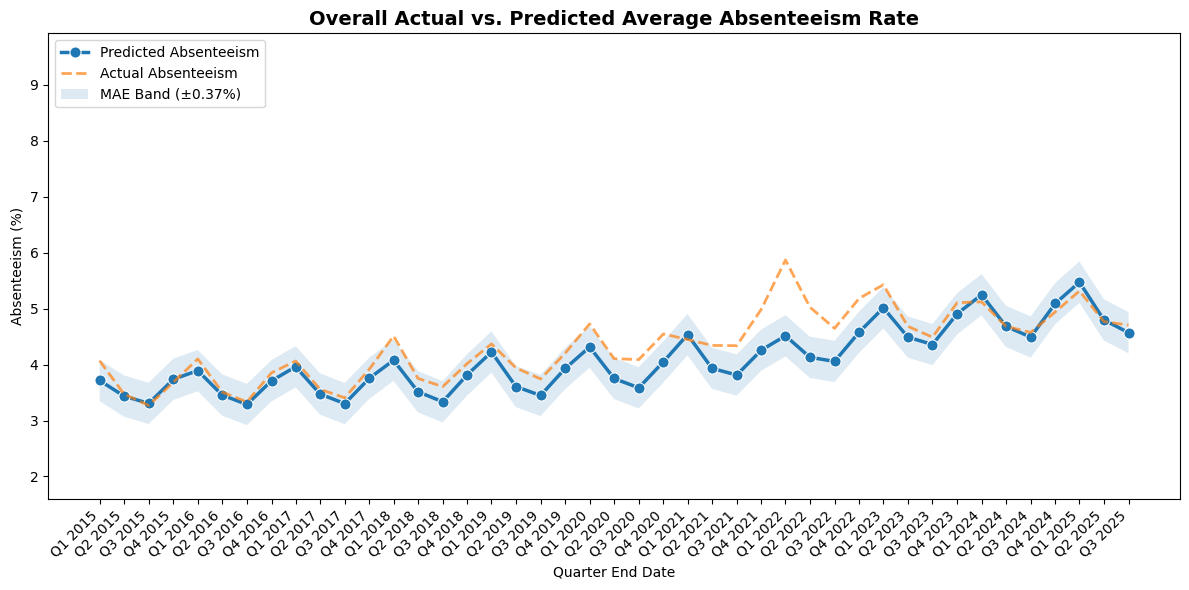

In [248]:
# 1. Prepare the figure
fig, ax = plt.subplots(figsize=(12, 6))

# 2. Plot Predicted Absenteeism (Primary Line with Markers)
sns.lineplot(
    data=df_plot, 
    x="period_enddate", 
    y="baseline_prediction",
    label="Predicted Absenteeism",
    marker="o", 
    errorbar=None,
    ax=ax,
    color="tab:blue",
    linewidth=2.5,
    markersize=8
)

# 3. Plot Actual Absenteeism (Reference Line - No Markers)
sns.lineplot(
    data=df_plot, 
    x="period_enddate", 
    y="absenteeism_perc",
    label="Actual Absenteeism",
    marker=None,        # Explicitly remove markers
    errorbar=None,
    ax=ax,
    color="tab:orange",
    linewidth=2,
    linestyle="--",     # Dashed line helps distinguish it as a reference
    alpha=0.7           # Slightly faded to keep focus on predictions
)

# # 4. Calculate means and annotate markers ONLY for the Predicted line
# df_means = df_plot.groupby("period_enddate")["baseline_prediction"].mean().reset_index()

# for _, row in df_means.iterrows():
#     ax.annotate(
#         text=f"{row['baseline_prediction']:.1f}%",
#         xy=(row["period_enddate"], row["baseline_prediction"]),
#         xytext=(0, 12),
#         textcoords="offset points",
#         ha="center",
#         va="bottom",
#         fontsize=9,
#         fontweight="bold",
#         color="tab:blue"
#     )

#5. Adding MAE Bandwith
# Get the unique x-axis values and the average predictions for the band
# We sort by date to ensure the 'fill' connects correctly
df_band = df_plot.groupby("period_enddate")["baseline_prediction"].mean().reset_index()

# Create the shaded area
ax.fill_between(
    df_band["period_enddate"],
    df_band["baseline_prediction"] - global_mae,
    df_band["baseline_prediction"] + global_mae,
    color="tab:blue",
    alpha=0.15,          # Light transparency
    label=f"MAE Band (±{global_mae:.2f}%)",
    edgecolor="none"     # Removes the hard line around the band
)
# 5. Final Formatting
ax.set_title("Overall Actual vs. Predicted Average Absenteeism Rate", fontsize=14, fontweight="bold")
ax.set_xlabel("Quarter End Date")
ax.set_ylabel("Absenteeism (%)")

# Ensure x-axis ticks match the data points
unique_dates = sorted(df_plot["period_enddate"].unique())
tick_labels = [f"Q{((d.month - 1) // 3) + 1} {d.year}" for d in unique_dates]

ax.set_xticks(unique_dates)
ax.set_xticklabels(tick_labels, rotation=45, ha="right")

# Adjust limits for headroom
ax.set_ylim(df_plot["absenteeism_perc"].min() * 0.8, df_plot["baseline_prediction"].max() * 1.2)

ax.legend(loc="upper left", frameon=True)
plt.tight_layout()
plt.show()

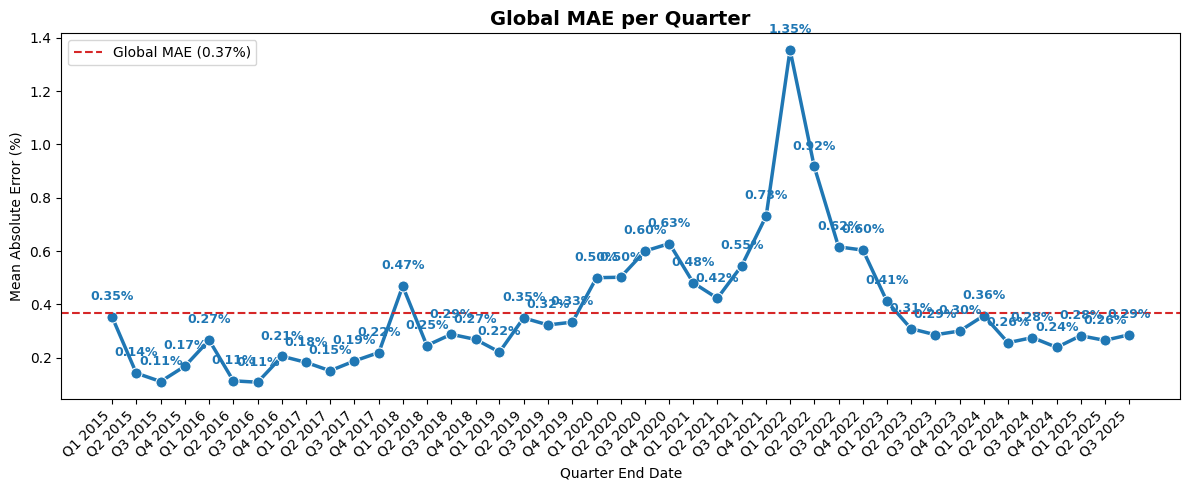

In [251]:
# Prepare evaluation dataframe in pandas for plotting
df_eval_pd = df_eval.drop_nulls().to_pandas()

# --- Plot 1: Global MAE per Quarter End Date ---
mae_per_quarter = (
    df_eval_pd.groupby("period_enddate")["abs_error"]
    .mean()
    .reset_index()
    .rename(columns={"abs_error": "mae"})
    .sort_values("period_enddate")
)

fig, ax = plt.subplots(figsize=(12, 5))

sns.lineplot(
    data=mae_per_quarter,
    x="period_enddate",
    y="mae",
    marker="o",
    color="tab:blue",
    linewidth=2.5,
    markersize=8,
    ax=ax
)

# Annotate each point
for _, row in mae_per_quarter.iterrows():
    ax.annotate(
        text=f"{row['mae']:.2f}%",
        xy=(row["period_enddate"], row["mae"]),
        xytext=(0, 12),
        textcoords="offset points",
        ha="center",
        fontsize=9,
        fontweight="bold",
        color="tab:blue"
    )

# Add global MAE as a reference line
ax.axhline(global_mae, color="tab:red", linestyle="--", linewidth=1.5, label=f"Global MAE ({global_mae:.2f}%)")

unique_dates = sorted(mae_per_quarter["period_enddate"].unique())
tick_labels = [f"Q{((d.month - 1) // 3) + 1} {d.year}" for d in unique_dates]
ax.set_xticks(unique_dates)
ax.set_xticklabels(tick_labels, rotation=45, ha="right")

ax.set_title("Global MAE per Quarter", fontsize=14, fontweight="bold")
ax.set_xlabel("Quarter End Date")
ax.set_ylabel("Mean Absolute Error (%)")
ax.legend(loc="upper left")
plt.tight_layout()
plt.show()

**Step 3: Plot the Time Series per SBI code**<br>
First chart shows the MAE per SBI Code (very crowded graph, need to fix that)
Below this are charts per SBI code that show prediction vs. actual.

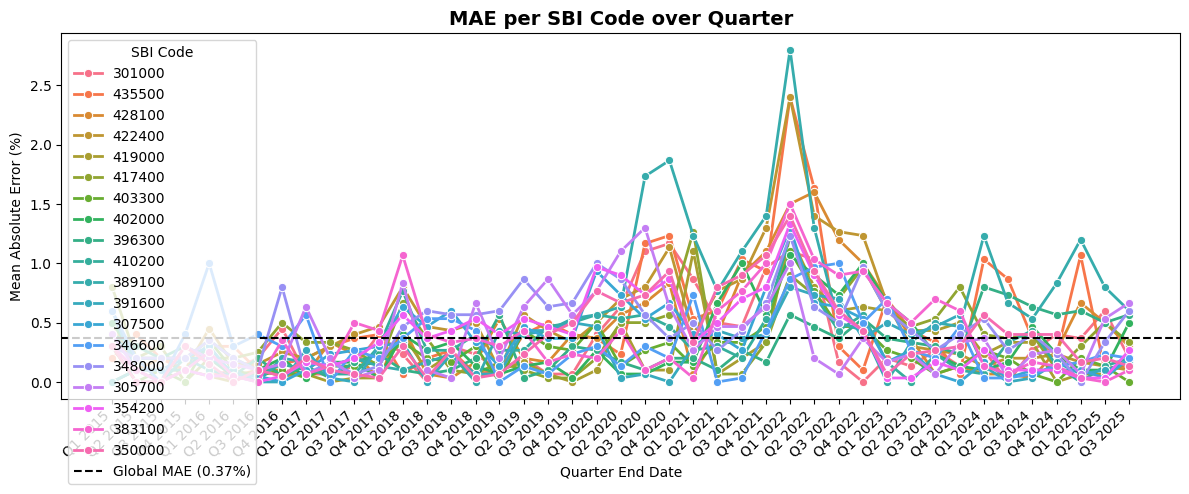

In [252]:
# Prepare evaluation dataframe in pandas for plotting
df_eval_pd = df_eval.drop_nulls().to_pandas()

# MAE per SBI Code over Quarter End Date ---
mae_per_sbi_quarter = (
    df_eval_pd.groupby(["period_enddate", "sbi_code"])["abs_error"]
    .mean()
    .reset_index()
    .rename(columns={"abs_error": "mae"})
    .sort_values("period_enddate")
)

fig, ax = plt.subplots(figsize=(12, 5))

sns.lineplot(
    data=mae_per_sbi_quarter,
    x="period_enddate",
    y="mae",
    hue="sbi_code",
    marker="o",
    linewidth=2,
    markersize=6,
    errorbar=None,
    ax=ax
)

# Add global MAE as a reference line
ax.axhline(global_mae, color="black", linestyle="--", linewidth=1.5, label=f"Global MAE ({global_mae:.2f}%)")

unique_dates = sorted(mae_per_sbi_quarter["period_enddate"].unique())
tick_labels = [f"Q{((d.month - 1) // 3) + 1} {d.year}" for d in unique_dates]
ax.set_xticks(unique_dates)
ax.set_xticklabels(tick_labels, rotation=45, ha="right")

ax.set_title("MAE per SBI Code over Quarter", fontsize=14, fontweight="bold")
ax.set_xlabel("Quarter End Date")
ax.set_ylabel("Mean Absolute Error (%)")
ax.legend(loc="upper left", title="SBI Code")
plt.tight_layout()
plt.show()

#### Visuals per SBI code

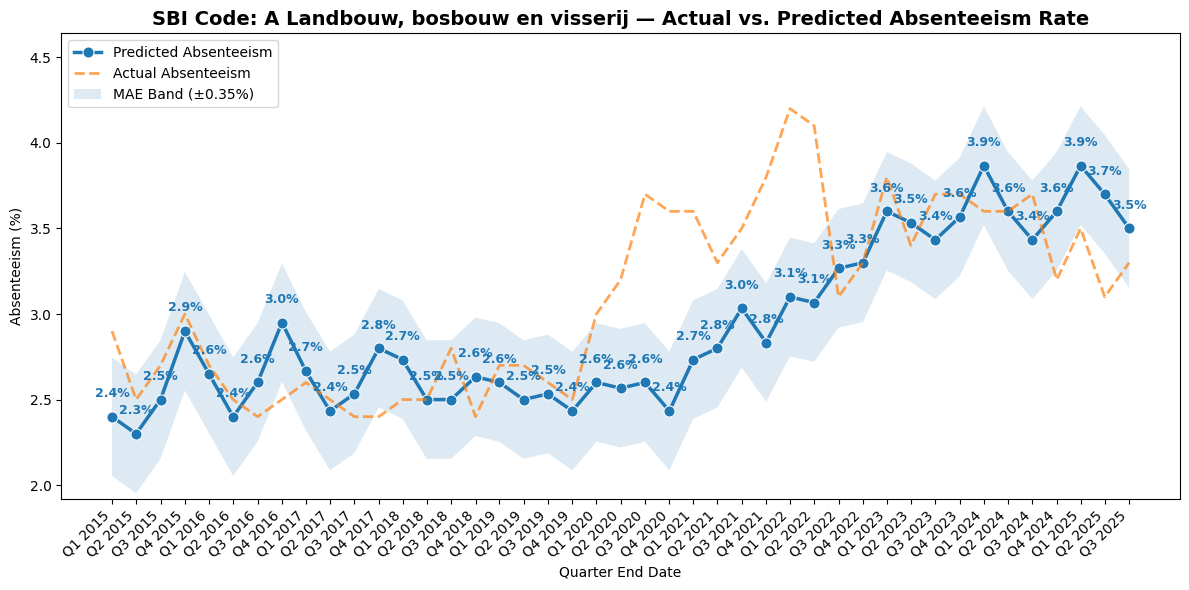

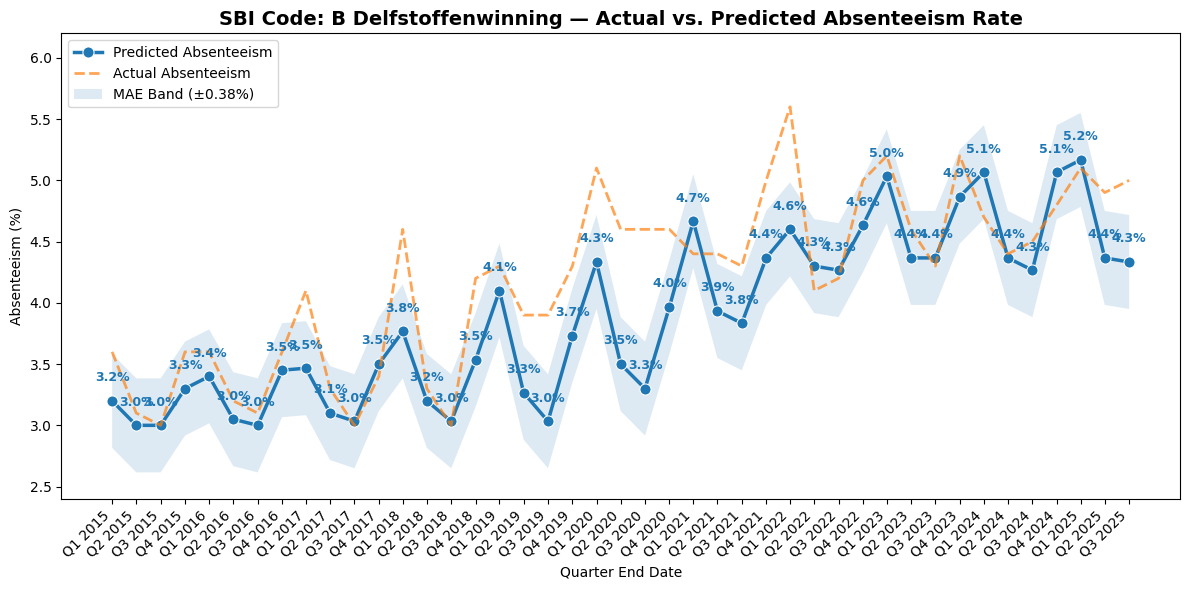

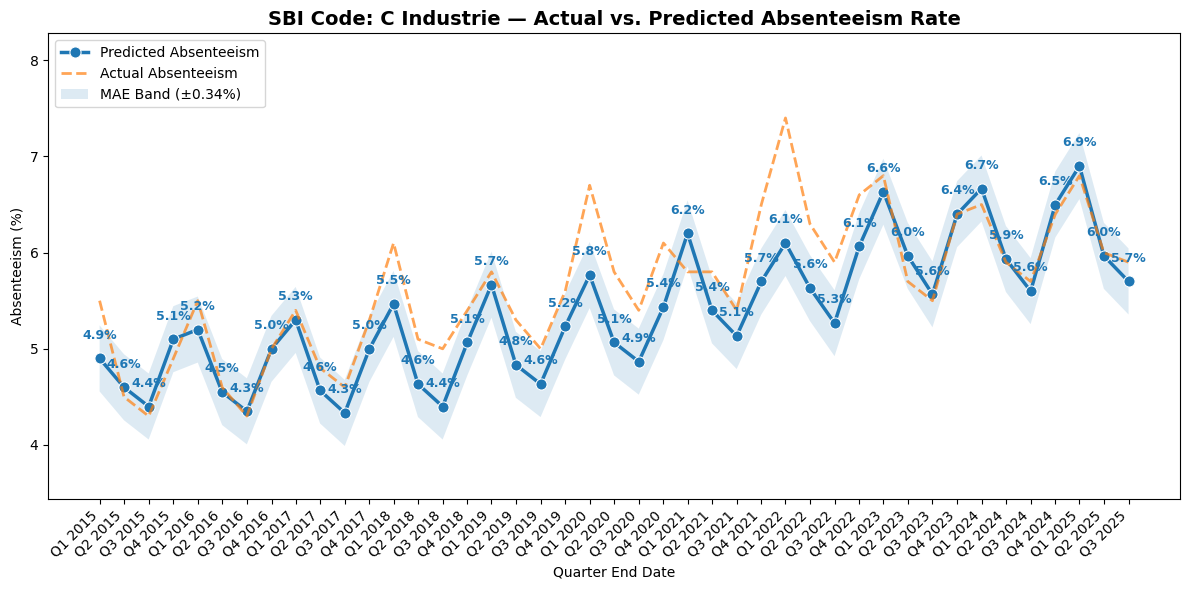

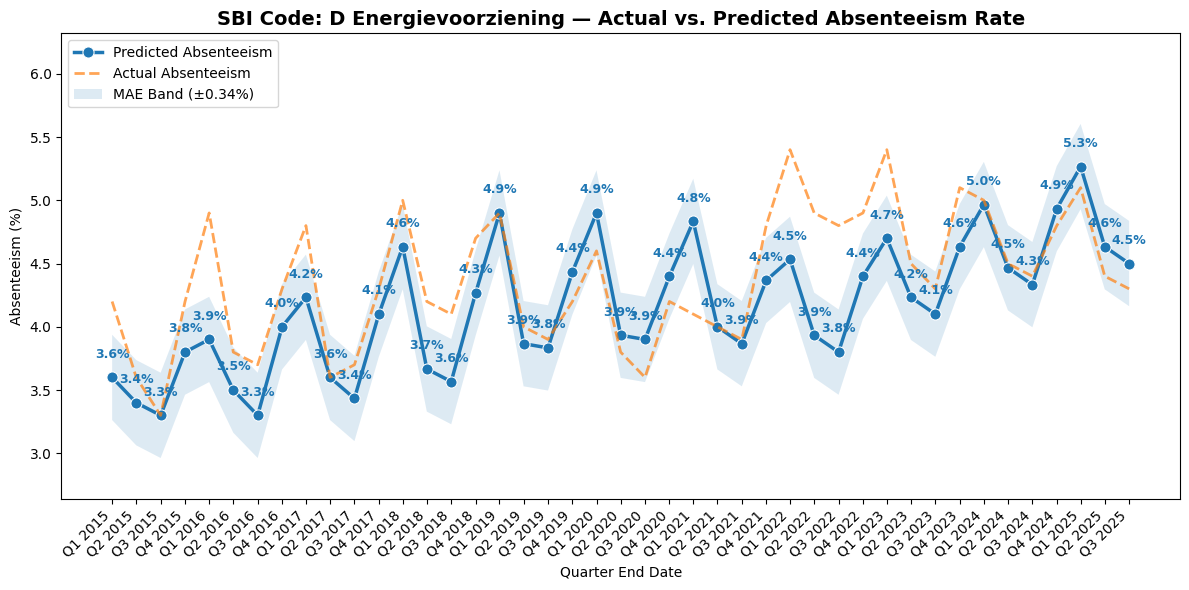

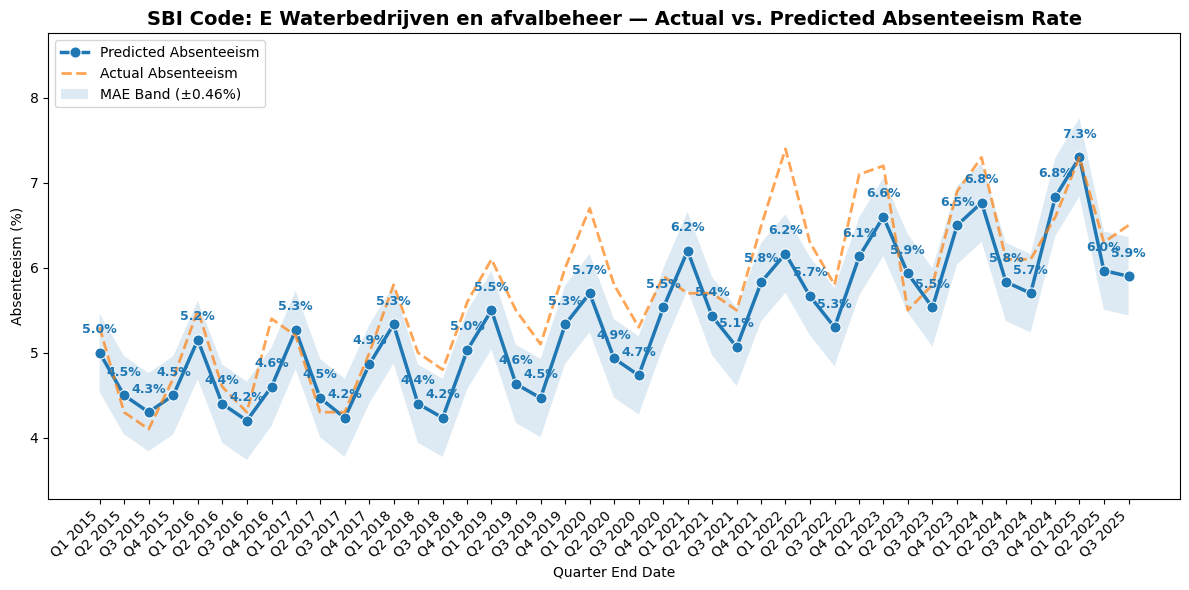

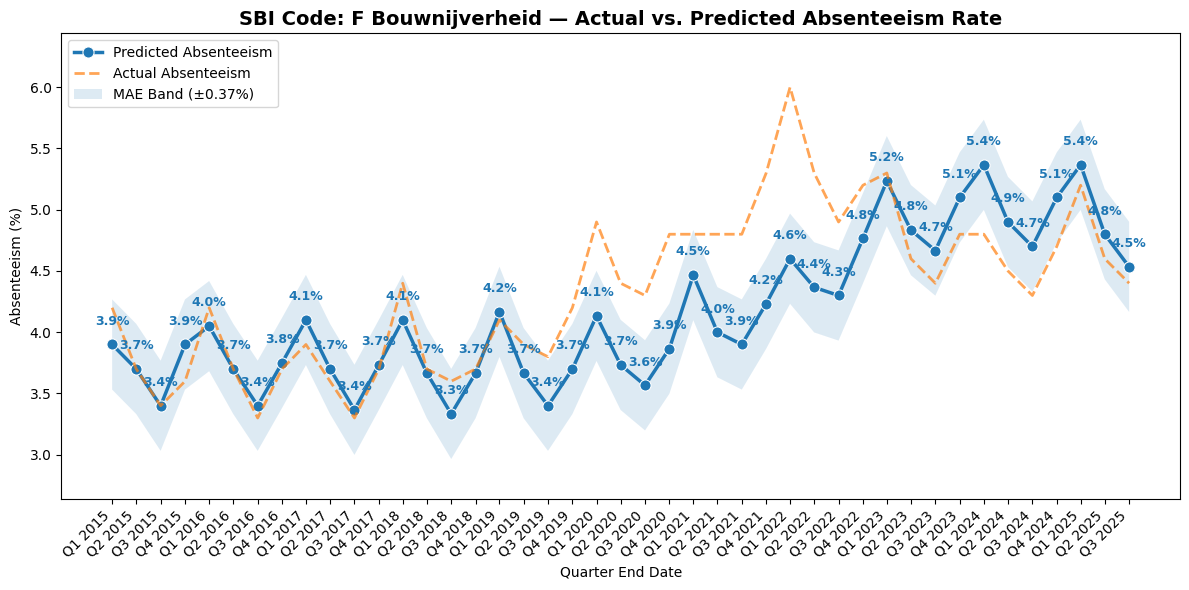

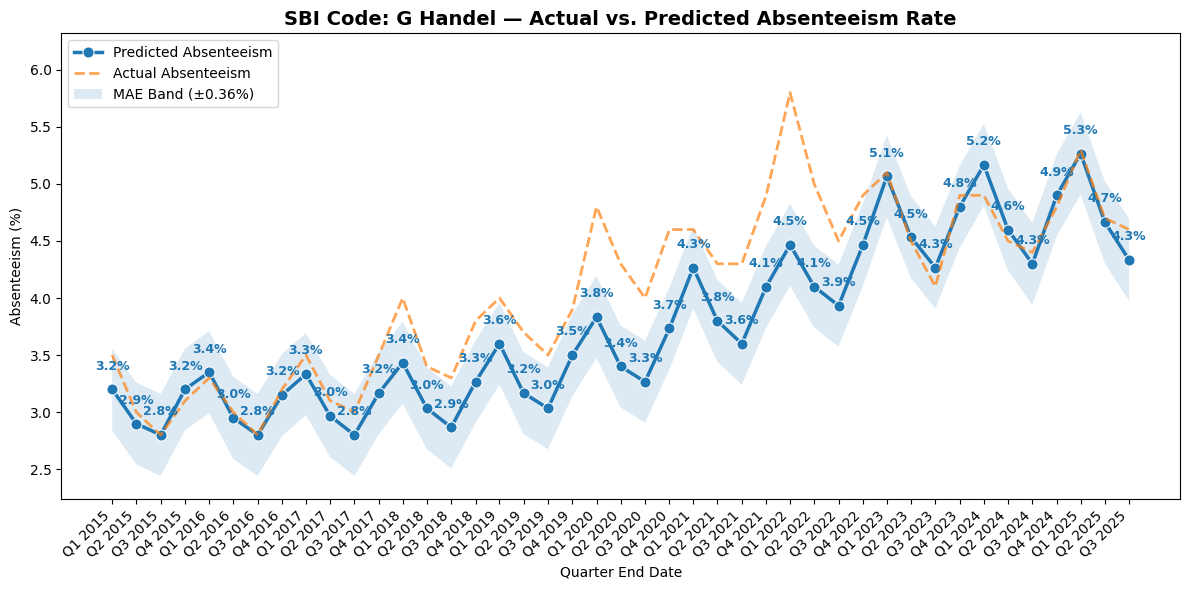

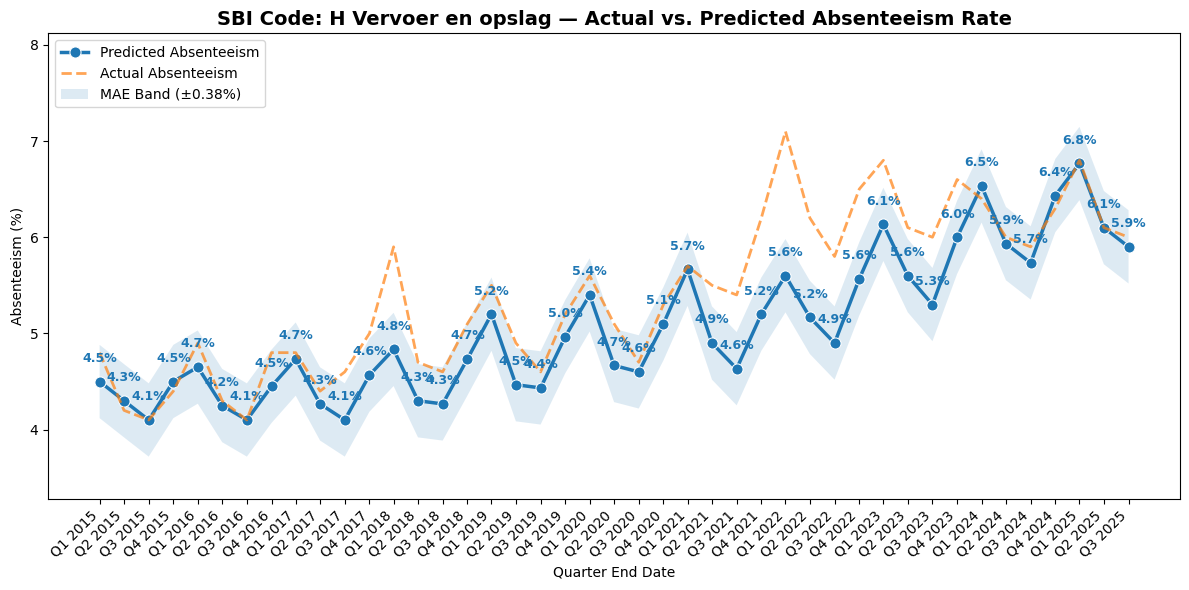

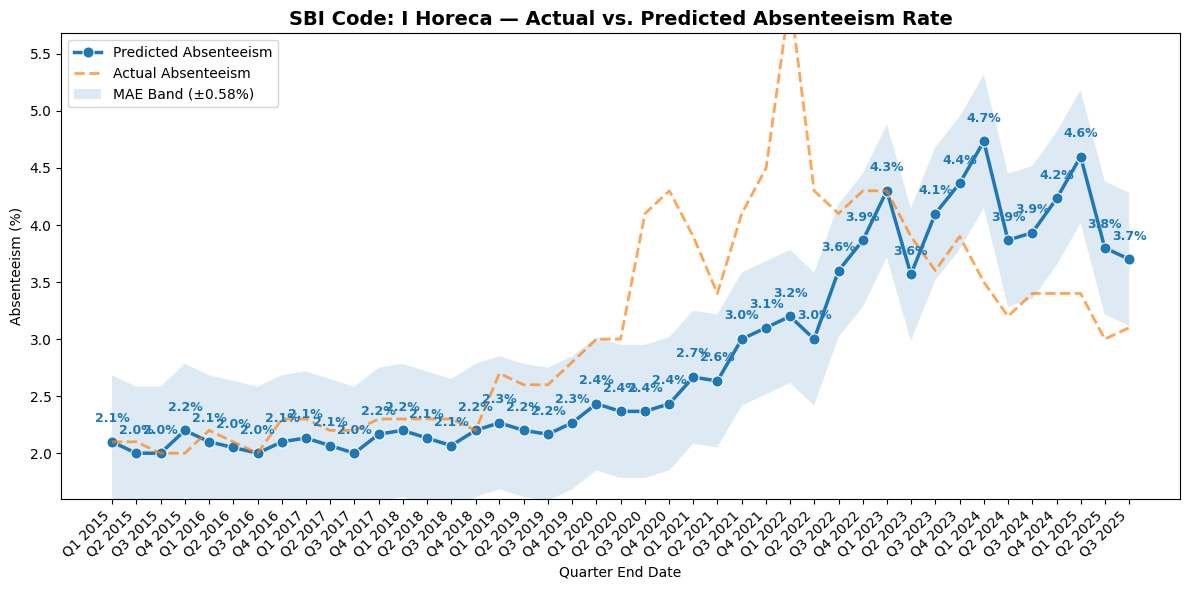

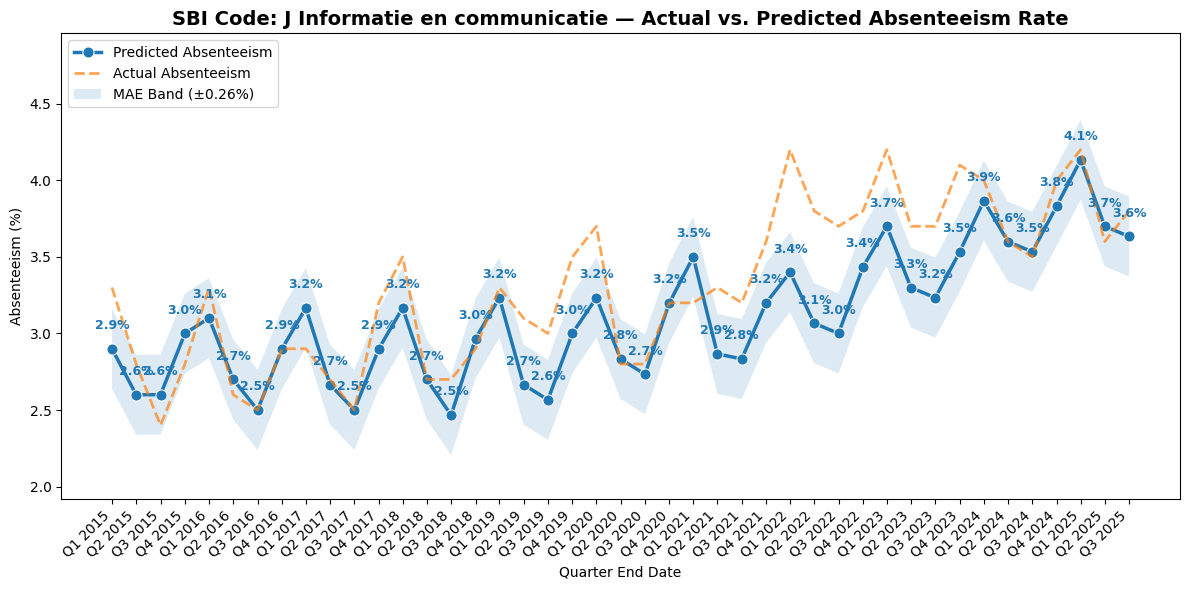

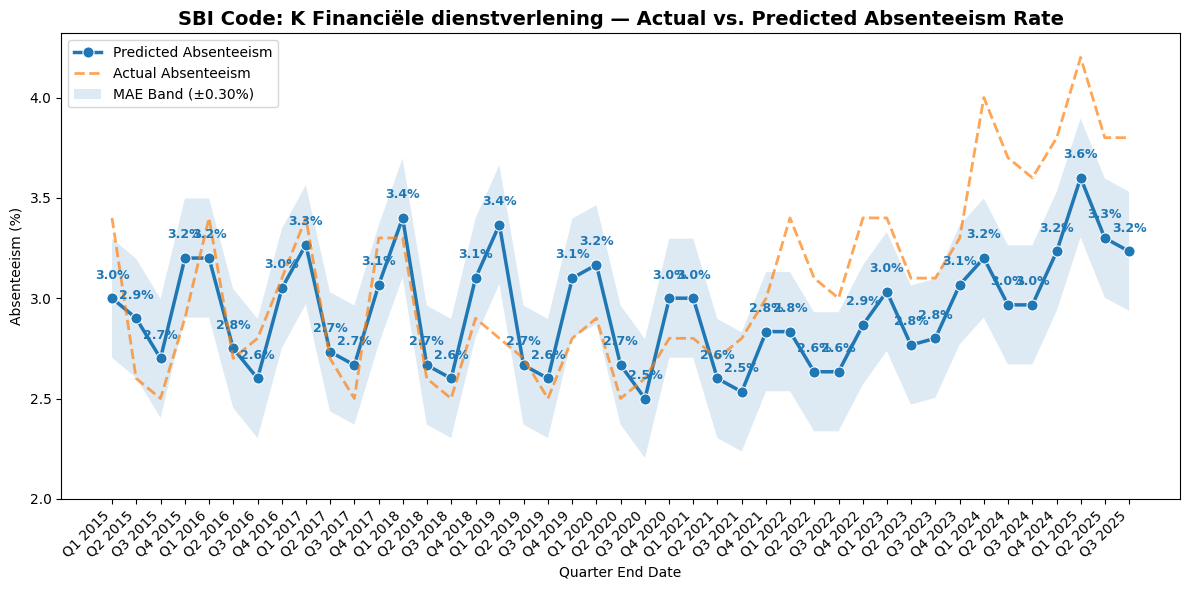

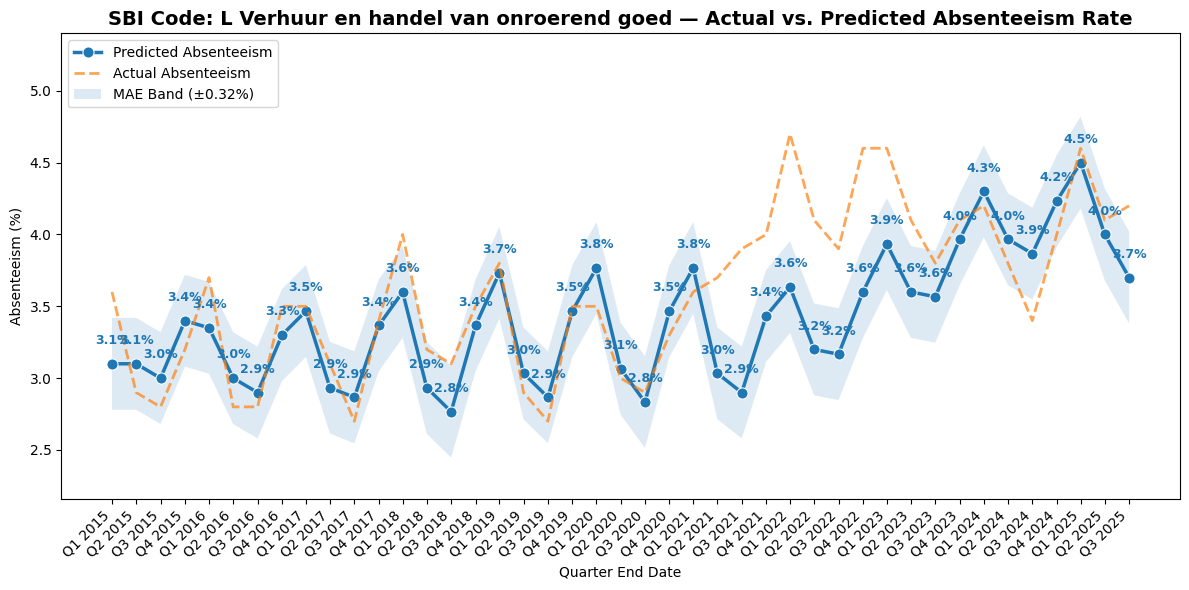

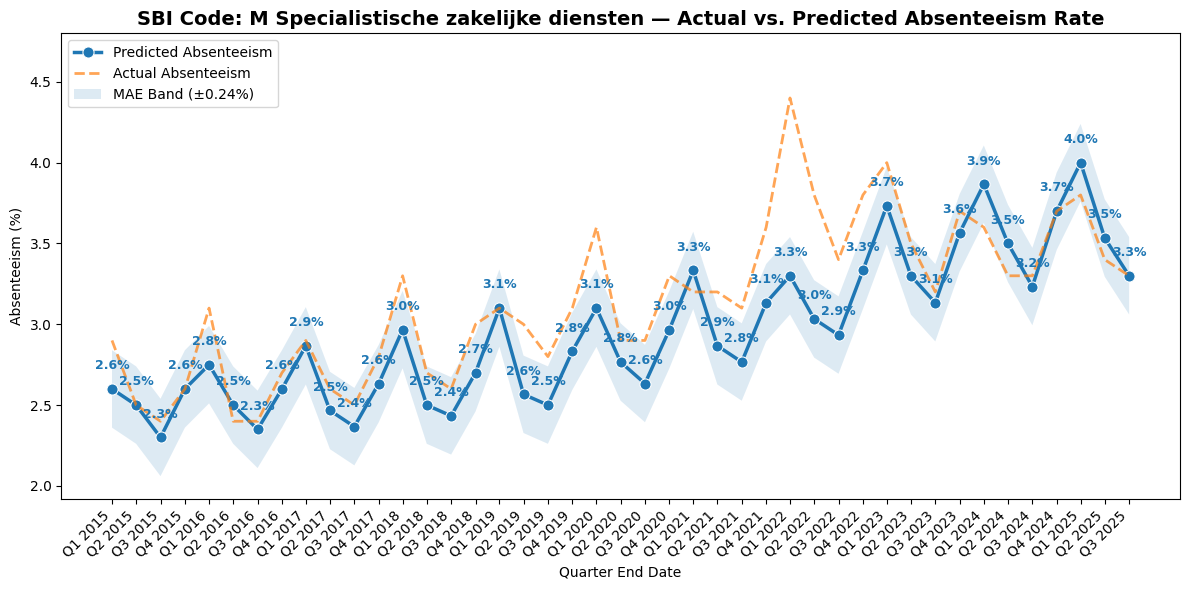

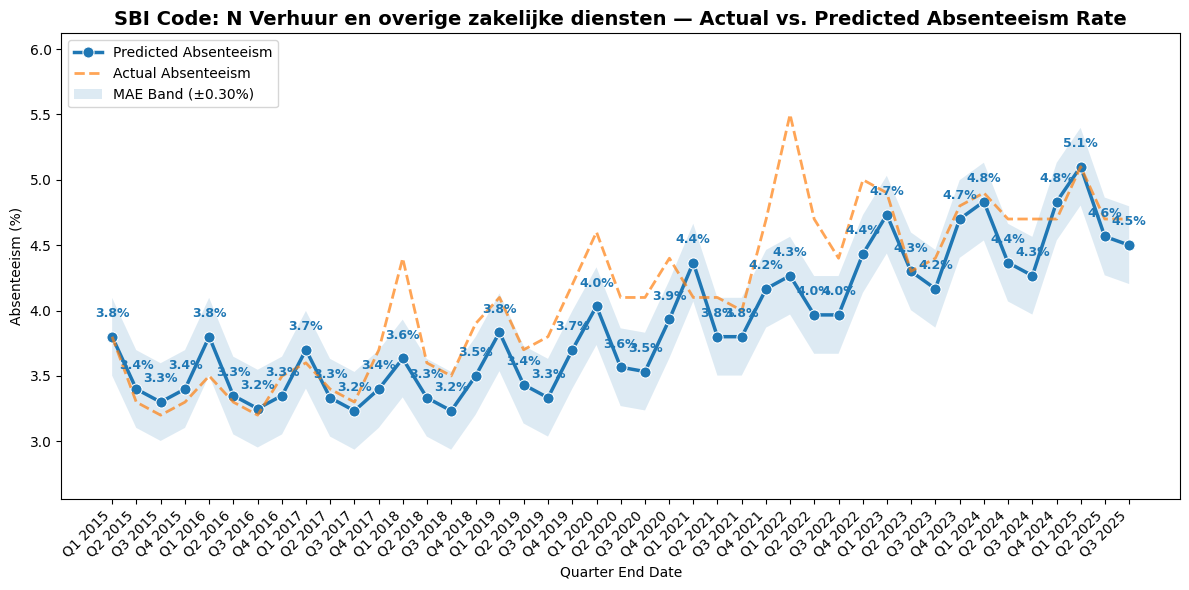

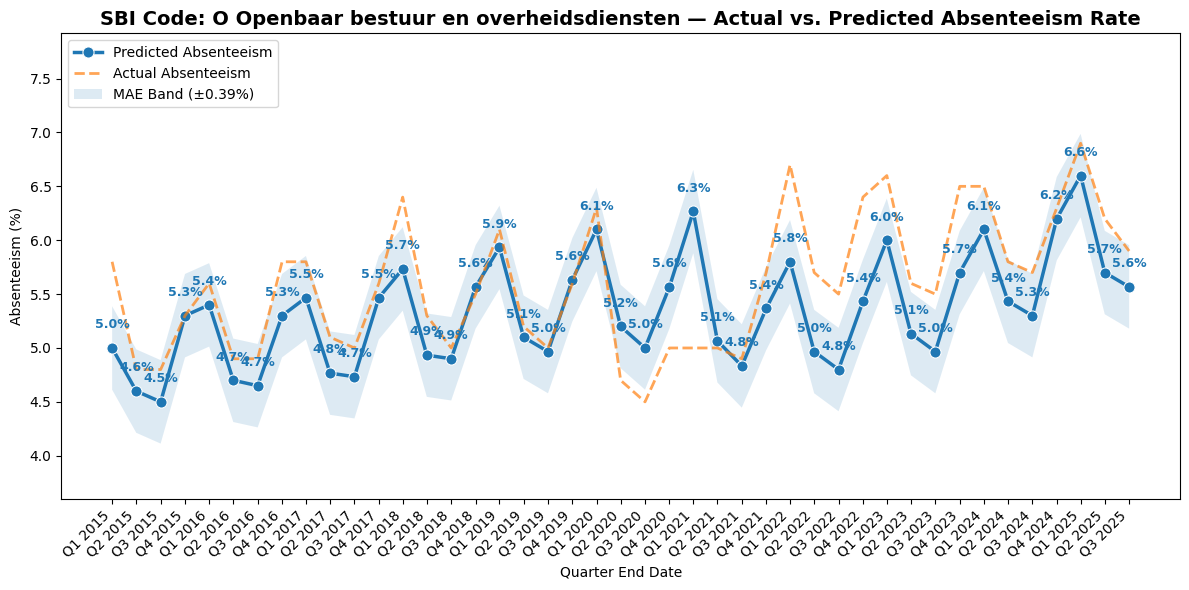

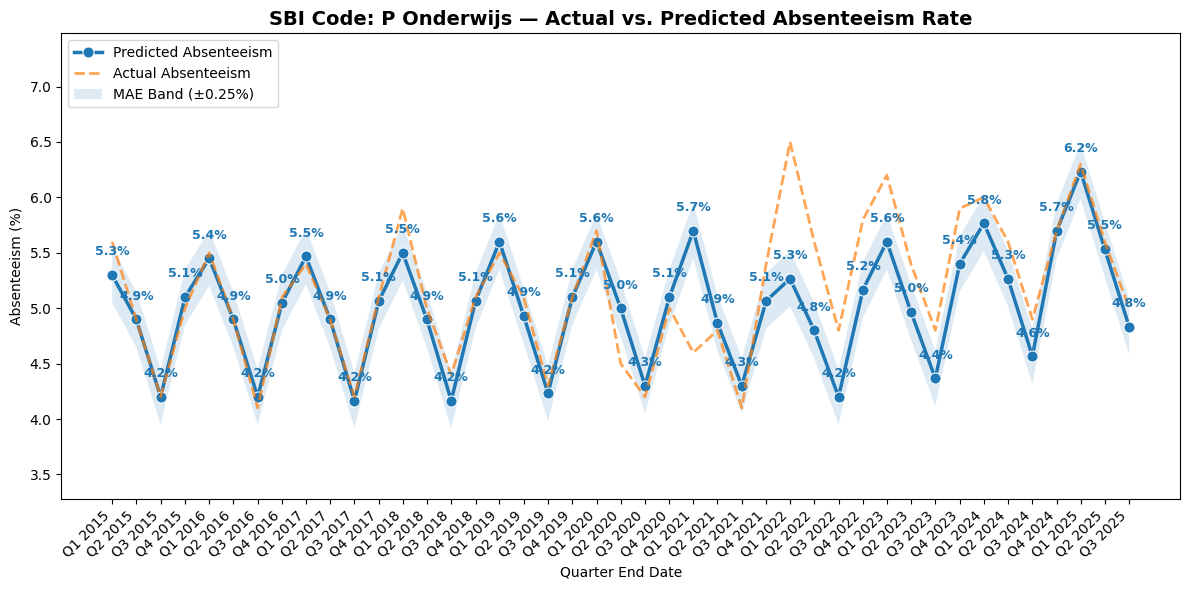

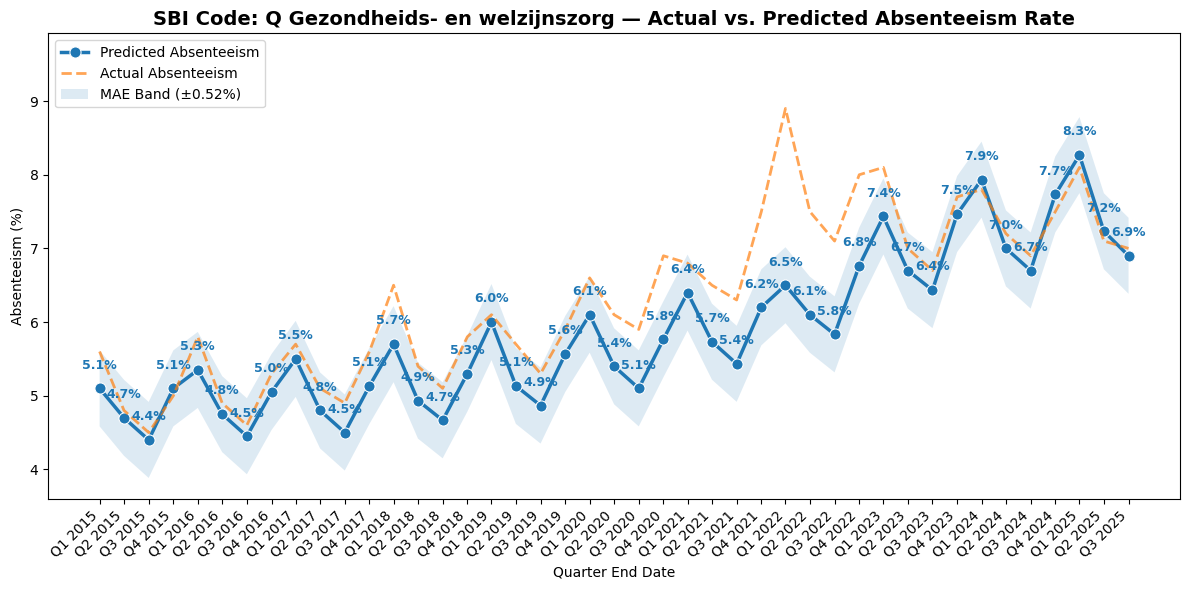

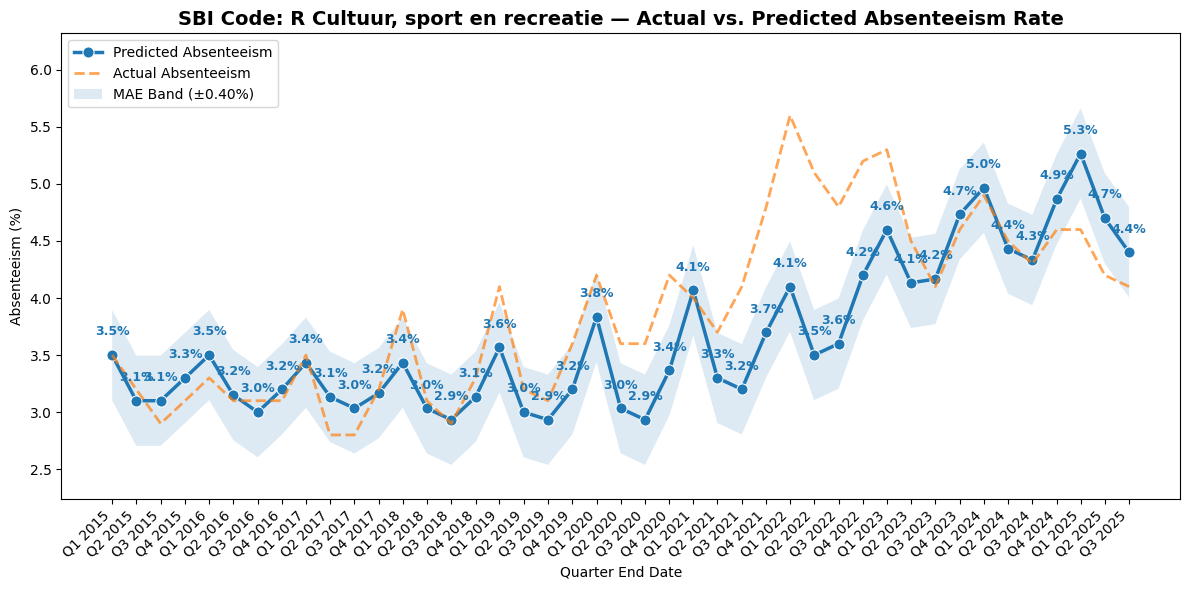

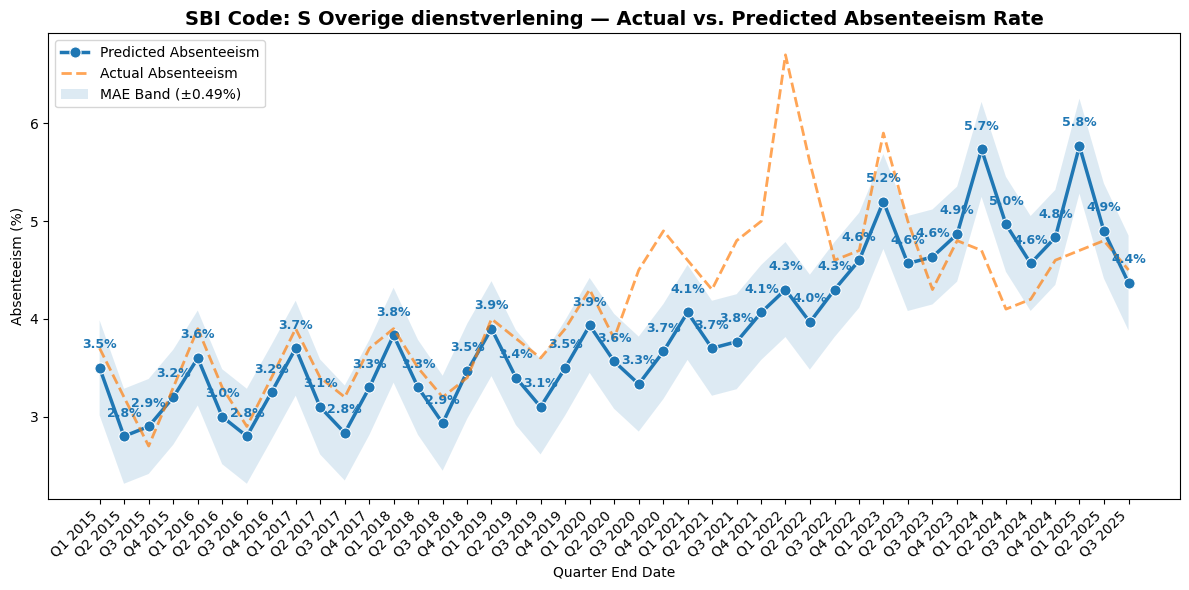

In [250]:
sbi_codes = sorted(df_plot["sbi_code"].unique())

for sbi_code in sbi_codes:
    df_sbi = df_plot[df_plot["sbi_code"] == sbi_code].copy().reset_index(drop=True)
    mae = mae_dict.get(sbi_code, 0)
    sbi_title = df_sbi["sbi_title"].iloc[0]  # Extract the title from the first row
    fig, ax = plt.subplots(figsize=(12, 6))

    # 1. Plot Predicted Absenteeism
    sns.lineplot(
        data=df_sbi,
        x="period_enddate",
        y="baseline_prediction",
        label="Predicted Absenteeism",
        marker="o",
        errorbar=None,
        ax=ax,
        color="tab:blue",
        linewidth=2.5,
        markersize=8
    )

    # 2. Plot Actual Absenteeism
    sns.lineplot(
        data=df_sbi,
        x="period_enddate",
        y="absenteeism_perc",
        label="Actual Absenteeism",
        marker=None,
        errorbar=None,
        ax=ax,
        color="tab:orange",
        linewidth=2,
        linestyle="--",
        alpha=0.7
    )

    # 3. Annotate markers for Predicted line
    for _, row in df_sbi.iterrows():
        ax.annotate(
            text=f"{row['baseline_prediction']:.1f}%",
            xy=(row["period_enddate"], row["baseline_prediction"]),
            xytext=(0, 12),
            textcoords="offset points",
            ha="center",
            va="bottom",
            fontsize=9,
            fontweight="bold",
            color="tab:blue"
        )

    # 4. MAE Bandwidth
    df_band = df_sbi.sort_values("period_enddate")

    ax.fill_between(
        df_band["period_enddate"],
        df_band["baseline_prediction"] - mae,
        df_band["baseline_prediction"] + mae,
        color="tab:blue",
        alpha=0.15,
        label=f"MAE Band (±{mae:.2f}%)",
        edgecolor="none"
    )

    # 5. Formatting
    ax.set_title(
        f"SBI Code: {sbi_title} — Actual vs. Predicted Absenteeism Rate",
        fontsize=14,
        fontweight="bold"
    )
    ax.set_xlabel("Quarter End Date")
    ax.set_ylabel("Absenteeism (%)")

    unique_dates = sorted(df_sbi["period_enddate"].unique())
    tick_labels = [f"Q{((d.month - 1) // 3) + 1} {d.year}" for d in unique_dates]

    ax.set_xticks(unique_dates)
    ax.set_xticklabels(tick_labels, rotation=45, ha="right")

    ax.set_ylim(df_sbi["absenteeism_perc"].min() * 0.8, df_sbi["baseline_prediction"].max() * 1.2)

    ax.legend(loc="upper left", frameon=True)
    plt.tight_layout()
    plt.show()